# Credit Valuation Adjustment (CVA) Modeling with Real Swap Curve Data

## 1. Introduction

This notebook presents a practical approach to estimating the Credit Valuation Adjustment (CVA), a key measure of counterparty credit risk in derivatives trading. The CVA represents the market value of the counterparty credit risk embedded in a derivative contract, reflecting the expected loss due to a potential default.

Using real-world interest rate swap data extracted from the Federal Reserve Economic Data (FRED), we simulate future exposure profiles and combine them with simplified credit parameters (Probability of Default and Loss Given Default) to estimate the CVA of a hypothetical interest rate derivative.

The project emphasizes:

- Working with real historical market data
- Interpolating swap curves to derive discount factors
- Simulating expected exposure through Monte Carlo
- Integrating credit risk inputs to calculate CVA

This hands-on quantitative project aims to demonstrate how core concepts in credit and counterparty risk can be implemented from scratch using Python tools such as `pandas`, `numpy`, `scipy`, and `matplotlib`.

## 2. Loading Market Data

In this section, we load and inspect the historical interest rate swap curve data extracted from the FRED database. These rates will later be used to interpolate discount factors, simulate future exposures, and value the derivative contract over time.

We begin by importing the required libraries and loading the data files.

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Charger les données individuelles
df_1y = pd.read_csv('/Users/danielosse/Documents/PROJETS PYTHON/CVA/Data/MSWP1.csv')
df_2y = pd.read_csv('/Users/danielosse/Documents/PROJETS PYTHON/CVA/Data/MSWP2.csv')
df_5y = pd.read_csv('/Users/danielosse/Documents/PROJETS PYTHON/CVA/Data/MSWP5.csv')
df_10y = pd.read_csv('/Users/danielosse/Documents/PROJETS PYTHON/CVA/Data/MSWP10.csv')
df_30y = pd.read_csv('/Users/danielosse/Documents/PROJETS PYTHON/CVA/Data/MSWP30.csv')

# Afficher la structure d'un fichier
df_1y.head()

,observation_date,MSWP1
0,2000-07-01,7.05
1,2000-08-01,6.95
2,2000-09-01,6.80
3,2000-10-01,6.70
4,2000-11-01,6.65


## 3. Data Preparation and Time Series Alignment

In this section, we clean and align the raw interest rate swap data collected from FRED. Each dataset corresponds to a specific maturity (1Y, 2Y, 3Y, 5Y, and 10Y), and contains monthly observations.
We begin by renaming the rate columns for clarity and converting the observation dates to proper datetime format. We then merge all datasets on the common observation_date to create a single, consolidated time series.
Finally, we ensure all maturities are aligned over the same time horizon and check for any missing values, which could impact curve construction and further modeling.

In [414]:
for df, maturity in zip([df_1y, df_2y, df_5y, df_10y, df_30y],['1Y','2Y','5Y','10Y','30Y']):
    df.rename(columns ={df.columns[1] : maturity}, inplace = True)
    df['observation_date'] = pd.to_datetime(df['observation_date'])

In [415]:
# Fusionner les séries

df_all = df_1y.copy()

for df in [df_2y, df_5y, df_10y, df_30y]:
    df_all = pd.merge(df_all, df, on = 'observation_date', how = 'inner')

df_all.set_index('observation_date', inplace = True)
 

In [416]:
# Aperçu des données
df_all.head()

# Dimensions
print(df_all.shape)

# Dates extrêmes
print(df_all.index.min(),df_all.index.max())

# Valeurs manquantes
print(df_all.isna().sum())


(195, 5)
2000-07-01 00:00:00 2016-09-01 00:00:00
1Y     0
2Y     0
5Y     0
10Y    0
30Y    0
dtype: int64


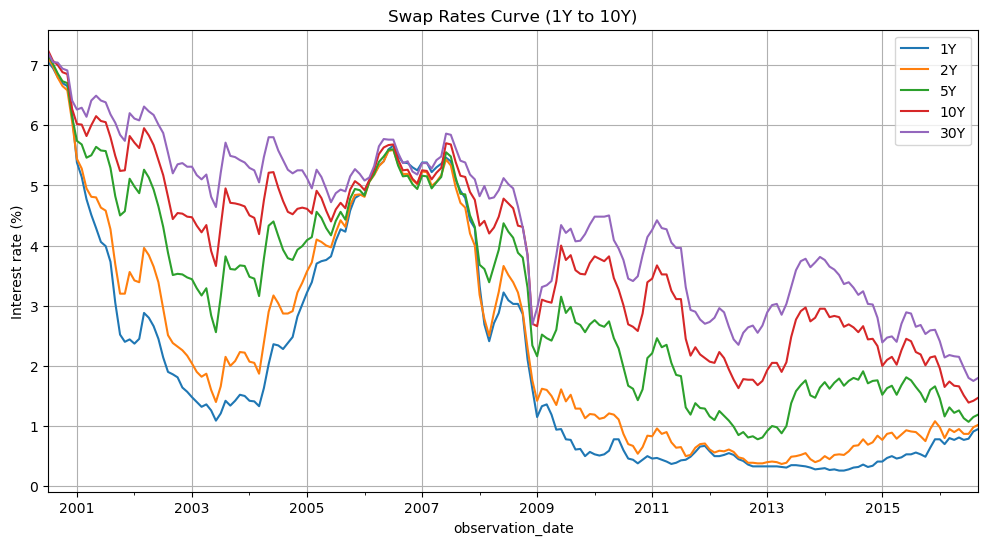

In [417]:
# Courbes de taux à travers le temps
df_all.plot(figsize = (12,6), title = 'Swap Rates Curve (1Y to 10Y)')
plt.ylabel('Interest rate (%)')
plt.grid()
plt.show()

## 4. Yield Curve Construction and Discount Factors

We now construct a continuous yield curve from the discrete swap rates previously collected.  
This curve allows us to determine the appropriate discount factor for any future cash flow.  
To do so, we interpolate the interest rates over time and convert them into discount factors using the exponential discounting formula.  
These discount factors are crucial for computing the present value of future exposures in the CVA calculation.

In [419]:
# Swap maturities in year
maturities = np.array([1,2,5,10,30]) # in year

# Choose the latest date
latest_date = df_all.index.max()
print('Latest data date :', latest_date)

Latest data date : 2016-09-01 00:00:00


In [420]:
# Rates corresponding to this date
rates_latest = df_all.loc[df_all.index == latest_date, ['1Y','2Y','5Y','10Y','30Y']].values.flatten()
print('Rates at latest date :', rates_latest)

Rates at latest date : [0.95 1.02 1.19 1.47 1.8 ]


In [421]:
# Interpolate with linear spline function
interp_func = interp1d(maturities, rates_latest, kind = 'linear', fill_value  ='extrapolate')

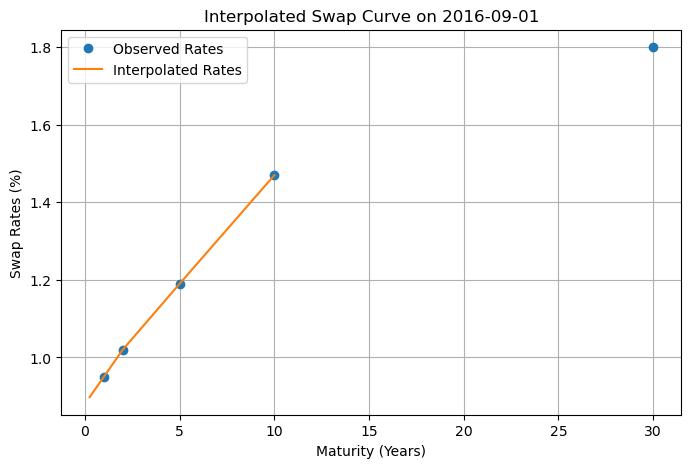

In [422]:
# Draw the interpolate curve
t_grid = np.linspace(0.25,10,40)
rates_interp = interp_func(t_grid)

#Original and interpolate curve
plt.figure(figsize = (8,5))
plt.plot(maturities, rates_latest, 'o', label = 'Observed Rates')
plt.plot(t_grid, rates_interp, '-', label = 'Interpolated Rates')
plt.xlabel('Maturity (Years)')
plt.ylabel('Swap Rates (%)')
plt.title(f'Interpolated Swap Curve on {latest_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In this section, we finalize the yield curve construction by computing discount factors for each quarterly maturity point using the interpolated interest rates. These discount factors are essential for the present value calculations of future exposures, which are the basis for CVA estimation.

We now compute discount factors using the interpolated zero-coupon rates and assuming continuous compounding. This step allows us to estimate the present value of future exposures, which is a fundamental component in CVA calculation.

The formula used is:

$$
DF(t) = e^{-r(t) \cdot t}
$$

where $r(t)$ is the continuously compounded zero rate for maturity $t$.

In [425]:
rates_interp = rates_interp / 100
continuous_rates = np.log(1 + rates_interp)

discount_factors = np.exp(-continuous_rates * t_grid)

In [426]:
df_discount = pd.DataFrame({
    'Maturity' : t_grid,
    'Rates' : continuous_rates,
    'DiscountFactor' : discount_factors
})

In [427]:
df_discount

,Maturity,Rates,DiscountFactor
0,0.25,0.008935,0.997769
1,0.50,0.009108,0.995456
2,0.75,0.009282,0.993063
3,1.00,0.009455,0.990589
4,1.25,0.009628,0.988037
5,1.50,0.009802,0.985405
6,1.75,0.009975,0.982695
7,2.00,0.010148,0.979908
8,2.25,0.010289,0.977117
9,2.50,0.010429,0.974265


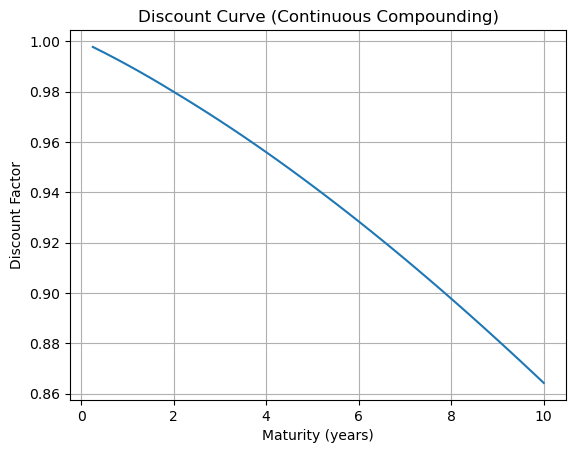

In [428]:
# Draw the discount Factor curve
plt.plot(t_grid, discount_factors)
plt.title('Discount Curve (Continuous Compounding)')
plt.xlabel('Maturity (years)')
plt.ylabel('Discount Factor')
plt.grid(True)
plt.show()

## 5. Exposure Profile Simulation

In this section, we simulate the future exposure profile of a simplified derivative instrument: a plain vanilla interest rate swap (IRS). The exposure profile, specifically the Expected Exposure (EE), is a critical component in Credit Valuation Adjustment (CVA) estimation.

We simulate the evolution of short-term interest rates using a basic stochastic model and compute the mark-to-market value of the IRS over a time grid. The positive part of the mark-to-market represents the exposure at each time point, which we discount in later steps for CVA estimation.

### 5.1 Parameters for simulation
Define notional, fixed rate, volatility, time horizon, and simulation settings.

In [432]:
# Notional of the swap
notional = 1_000_000

# Time settings
T = 10
n_steps = 40
dt = T / n_steps
time_grid = np.linspace(0, T, n_steps + 1)

# Number of Monte Carlo simulations
n_simulations = 5000

### 5.2 Short-rate simulation

To assess the future exposure of the interest rate swap, we simulate the evolution of short-term interest rates over time using a stochastic process. Specifically, we use a **Brownian motion with constant drift**, a basic yet insightful model for prototyping Credit Valuation Adjustment (CVA).

The process follows the stochastic differential equation (SDE):

$$
dr(t) = \mu \, dt + \sigma \, dW(t)
$$

where:  
- $r(t)$ is the short rate at time $t$,  
- $\mu$ is the drift term, representing the average direction of rate changes,  
- $\sigma$ is the volatility of the rate, estimated from historical data,  
- $dW(t)$ is a Wiener process (Brownian motion increment).

The model is discretized using the Euler-Maruyama scheme:

$$
r_{t+\Delta t} = r_t + \mu \, \Delta t + \sigma \, \sqrt{\Delta t} \cdot \varepsilon_t
$$

with $\varepsilon_t \sim \mathcal{N}(0,1)$.

This model, though simplistic, is sufficient to generate plausible interest rate paths over a 10-year horizon for exposure analysis.

#### Model Parameters:
- **Initial rate**: taken from the interpolated zero-coupon yield curve at $t = 0$  
- **Drift ($\mu$)** and **Volatility ($\sigma$)**: estimated from the historical 1-year swap rates  
- **Simulation horizon**: 10 years  
- **Time step**: quarterly ($\Delta t = 0.25$)  
- **Number of paths**: 1,000 Monte Carlo simulations

The simulated paths will serve to construct future yield curves and compute the exposure of the swap contract at each time step.

In [434]:
df_all = df_all.copy()

In [435]:
r1 = df_all['1Y'].dropna()
log_returns = np.log(r1 / r1.shift(1)).dropna()
mu_monthly = log_returns.mean()
sigma_monthly = log_returns.std()

mu_annual = mu_monthly * 12
sigma_annual = sigma_monthly * np.sqrt(12)

print(f'μ (drift annuel) estimé = {mu_annual:.6f}')
print(f'σ (volatilité annuelle) estimé = {sigma_annual}')

μ (drift annuel) estimé = -0.123979
σ (volatilité annuelle) estimé = 0.35445701468239854


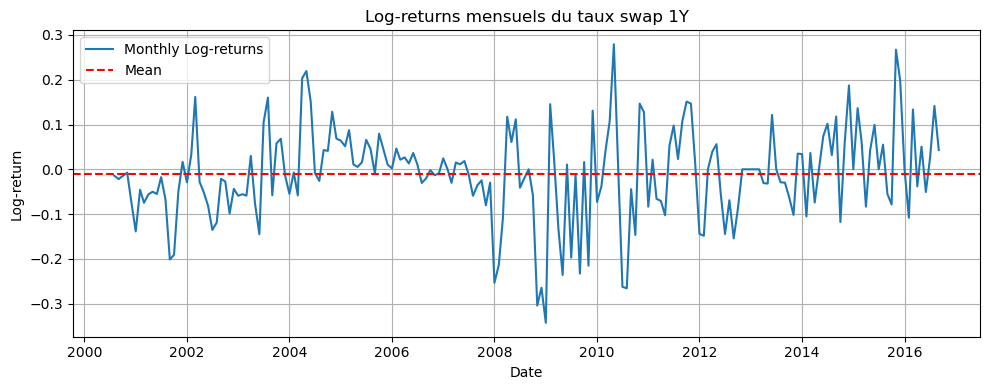

In [436]:
# Visualize the log-returns

plt.figure(figsize = (10,4))
plt.plot(log_returns, label = 'Monthly Log-returns')
plt.axhline(log_returns.mean(), color = 'red', linestyle = '--', label = 'Mean')
plt.title('Log-returns mensuels du taux swap 1Y')
plt.xlabel('Date')
plt.ylabel('Log-return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [437]:
# Initial rate
r0 = df_all['1Y'].dropna().iloc[-1]

print(f'Taux initial = {r0:.4%}')
print(f'Drift μ = {mu_annual:.4%}')
print(f'Volatility σ  = {sigma_annual:.4%}')

Taux initial = 95.0000%
Drift μ = -12.3979%
Volatility σ  = 35.4457%


In [438]:
np.random.seed(42)

r_sim = np.zeros((n_simulations, n_steps + 1))
r_sim[:,0] = r0

# Paths simulation
for t in range(1, n_steps + 1):
    z = np.random.normal(0,1,n_simulations)
    r_sim[:,t] = r_sim[:,t - 1] + mu_annual * dt + sigma_annual * np.sqrt(dt) * z 

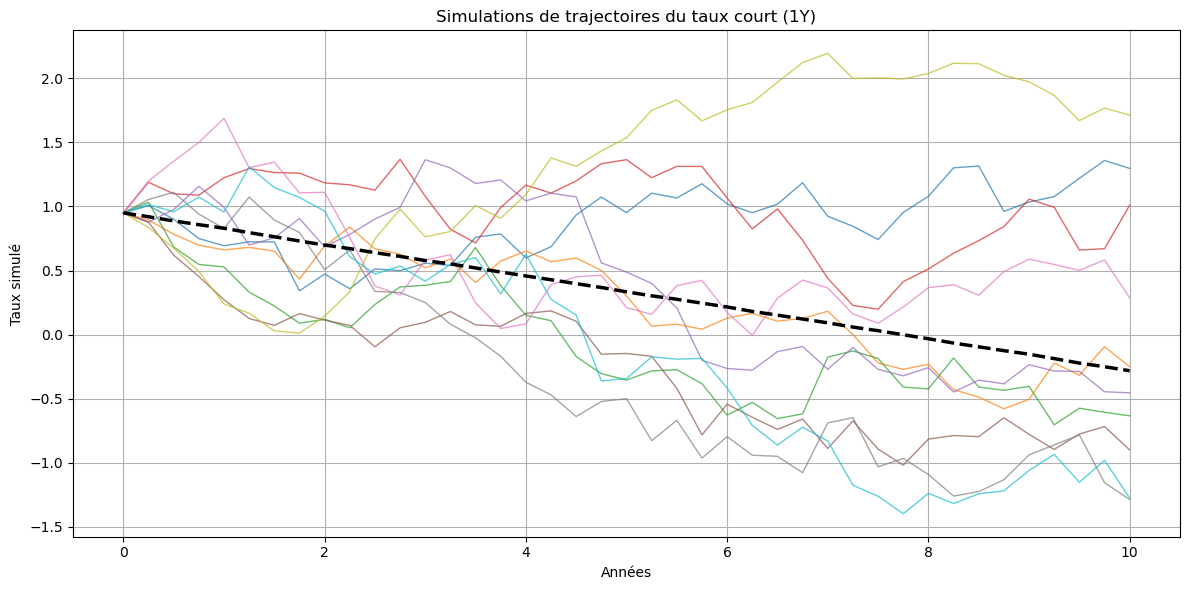

In [439]:
# Paths visualization

plt.figure(figsize = (12,6))
for i in range(10):
    plt.plot(time_grid, r_sim[i], lw=1, alpha = 0.7)
plt.plot(time_grid, r_sim.mean(axis=0), color="black", linewidth=2.5, linestyle='--', label='Moyenne des trajectoires')
plt.title('Simulations de trajectoires du taux court (1Y)')
plt.xlabel('Années')
plt.ylabel('Taux simulé')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.3 Swap Valuation Along Simulated Paths

#### 5.3.1 Construction of Forward Discount Factors

At each simulation time t, we assume that the simulated short rate represents a flat yield curve.  
We construct forward discount factors as follows:

$$
DF(t, T) = \exp\left(-r(t) \cdot (T - t)\right)
$$

These discount factors allow us to evaluate future swap cash flows at each time step.

---



In [441]:
discount_factors_list = []

for i in range(n_simulations):
    df_matrix = np.zeros((n_steps + 1, n_steps + 1))
    for t in range(n_steps + 1):
        rt = r_sim[i, t]  # taux simulé à la date t
        for T in range(t, n_steps + 1):
            delta = time_grid[T] - time_grid[t]
            df_matrix[t, T] = np.exp(-rt * delta)
    discount_factors_list.append(df_matrix)

In [442]:
discount_factors_list[0]

array([[1.00000000e+00, 7.88596891e-01, 6.21885056e-01, ...,
        1.20362805e-04, 9.49177339e-05, 7.48518299e-05],
       [0.00000000e+00, 1.00000000e+00, 7.77431833e-01, ...,
        9.00545819e-05, 7.00112987e-05, 5.44290123e-05],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.00981201e-04, 2.40281880e-04, 1.91823879e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 7.37125825e-01, 5.43354482e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 7.11885205e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### 5.3.2 Valuation of IRS at Each Time Step

Using the discount factors derived above, we compute the mark-to-market (MtM) value of a plain vanilla interest rate swap at each time point t.  
We assume quarterly payments and a notional of 1,000,000 €.

The MtM is given by:

$$
\text{MtM}_t = \text{PV}_{\text{floating}}(t) - \text{PV}_{\text{fixed}}(t)
$$

where:
- The fixed leg pays the contractual rate (e.g., 2%) quarterly,
- The floating leg is assumed to reset at the short rate \( r(t) \).

We only retain the positive part of MtM for Expected Exposure calculation.

In [444]:
fixed_rate = 0.02      
delta = 0.25           

In [445]:
mtm_matrix = np.zeros((n_simulations, n_steps + 1))

for i in range(n_simulations):
    df = discount_factors_list[i]
    for t in range(n_steps + 1):
        future_dates = range(t+1, n_steps+1)
        pv_fixed = notional * fixed_rate * delta * np.sum(df[t, future_dates])
        pv_float = notional * (1 - df[t,-1])
        mtm = pv_float - pv_fixed
        mtm_matrix[i, t] = mtm
        

### 5.4 – Compute Expected Exposure (EE)

At each time step $t$, we compute the Expected Exposure (EE), which is the average of the positive part of the mark-to-market value across all Monte Carlo paths.

Formally, the Expected Exposure at time $t$ is defined as:

$$
\text{EE}(t) = \mathbb{E} \left[ \max \left( \text{MtM}(t), 0 \right) \right]
$$

In a discrete Monte Carlo setting with $N$ simulated paths, this becomes:

$$
\text{EE}(t) = \frac{1}{N} \sum_{i=1}^{N} \max \left( \text{MtM}_i(t), 0 \right)
$$

This quantity represents the average future exposure of the swap at each point in time, under the assumption of no default.

We will use this exposure profile in the next steps to compute the Credit Valuation Adjustment (CVA).

In [447]:
exposure_matrix = np.maximum(mtm_matrix, 0)
expected_exposure =  exposure_matrix.mean(axis = 0)


In [448]:
for i, ee in enumerate(expected_exposure[:10]):
    print(f'EE(t={time_grid[i]:.2f} ans) = {ee:,.2f} €')

EE(t=0.00 ans) = 981,275.05 €
EE(t=0.25 ans) = 979,213.16 €
EE(t=0.50 ans) = 973,370.61 €
EE(t=0.75 ans) = 961,945.71 €
EE(t=1.00 ans) = 945,226.80 €
EE(t=1.25 ans) = 921,078.88 €
EE(t=1.50 ans) = 894,965.04 €
EE(t=1.75 ans) = 865,636.22 €
EE(t=2.00 ans) = 839,257.87 €
EE(t=2.25 ans) = 812,877.22 €


### 5.5 Visualize the exposure profile
Plot the EE over time to illustrate the future credit exposure.

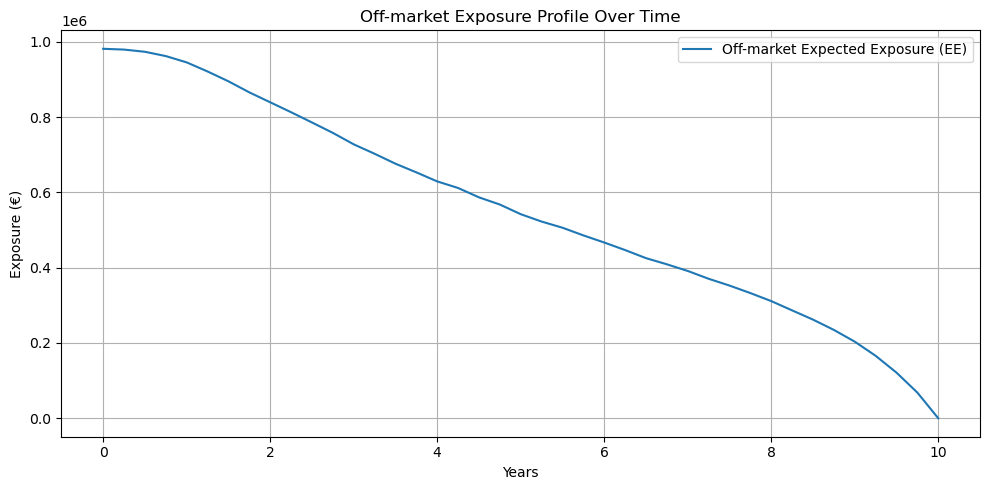

In [450]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(time_grid, expected_exposure, label='Off-market Expected Exposure (EE)')
plt.title("Off-market Exposure Profile Over Time")
plt.xlabel("Years")
plt.ylabel("Exposure (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 5.6 – Calibration of the Fair Fixed Rate

In the initial simulation, the fixed rate of the swap was arbitrarily set (e.g., 2%), which caused a very large mark-to-market value at inception and an unrealistically high Expected Exposure (EE) at $t = 0$.

To ensure that the swap is fairly valued at inception (i.e., $\text{MtM}(0) = 0$ and $\text{EE}(0) \approx 0$), we recompute the fair fixed rate based on the initial yield curve.

We use the following formula for the market-implied fixed rate:

$$
\text{FixedRate}_{\text{fair}} = \frac{1 - DF(0, T)}{\sum_{i=1}^{n} DF(0, t_i) \cdot \Delta}
$$

where:

- $DF(0, t_i)$ are the discount factors at time 0,
- $\Delta$ is the payment frequency (e.g., 0.25 for quarterly),
- $T$ is the final maturity (e.g., 10 years),
- $n = T / \Delta$ is the number of payment periods.


In [452]:
# Grille de paiement trimestrielle de 0.25 à 10 ans
payment_dates = np.arange(0.25, 10 + 0.25, 0.25)

# Taux zéro-coupon initial (en continu) interpolé à chaque date
zero_rates = interp_func(payment_dates)  

# Discount factors correspondants (taux en continu)
df_initial = np.exp(-zero_rates * payment_dates)

# Numerateur = 1 - DF(0, T_final)
numerator = 1 - df_initial[-1]

# Denominateur = somme des DF × delta
denominator = np.sum(df_initial) * 0.25

# Taux fixe équitable
fair_fixed_rate = numerator / denominator
print(f"Taux fixe du marché (fair rate) : {fair_fixed_rate:.6%}")

Taux fixe du marché (fair rate) : 113.981616%


In [453]:
mtm_matrix = np.zeros((n_simulations, n_steps + 1))

for i in range(n_simulations):
    df = discount_factors_list[i]
    for t in range(n_steps + 1):
        future_dates = range(t+1, n_steps+1)
        pv_fixed = notional * fair_fixed_rate * delta * np.sum(df[t, future_dates])
        pv_float = notional * (1 - df[t,-1])
        mtm = pv_float - pv_fixed
        mtm_matrix[i, t] = mtm

fair_exposure_matrix = np.maximum(mtm_matrix, 0)
fair_expected_exposure =  fair_exposure_matrix.mean(axis = 0)


In [454]:
for i, ee in enumerate(fair_expected_exposure[:10]):
    print(f'EE(t={time_grid[i]:.2f} ans) = {ee:,.2f} €')

EE(t=0.00 ans) = 0.00 €
EE(t=0.25 ans) = 34,566.43 €
EE(t=0.50 ans) = 47,322.81 €
EE(t=0.75 ans) = 54,645.27 €
EE(t=1.00 ans) = 60,030.06 €
EE(t=1.25 ans) = 60,538.32 €
EE(t=1.50 ans) = 62,254.47 €
EE(t=1.75 ans) = 63,210.45 €
EE(t=2.00 ans) = 62,299.93 €
EE(t=2.25 ans) = 63,063.32 €


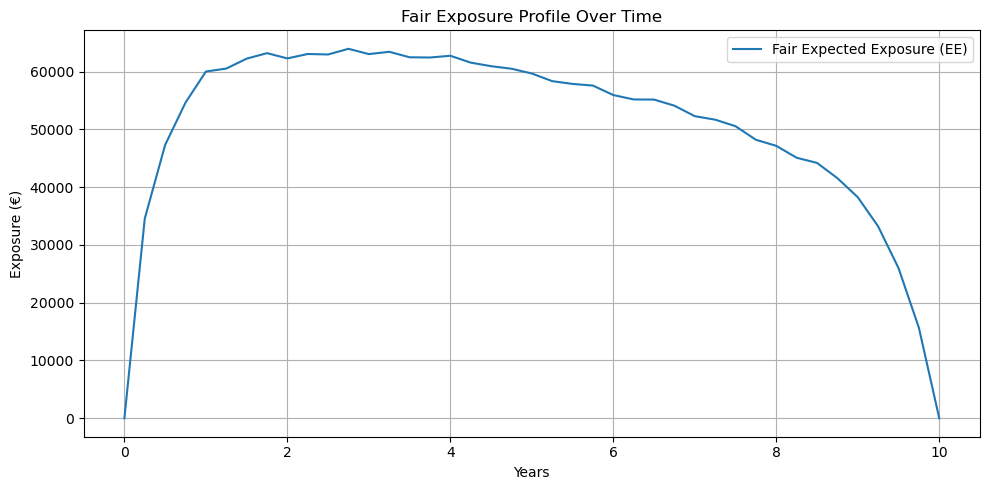

In [455]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(time_grid, fair_expected_exposure, label='Fair Expected Exposure (EE)')
plt.title("Fair Exposure Profile Over Time")
plt.xlabel("Years")
plt.ylabel("Exposure (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

After recalculating the fixed rate using the interpolated zero-coupon curve, we replaced the original fixed rate and reran the simulation.

As a result, the new Expected Exposure profile starts near zero, peaks around 2–3 years, and then gradually declines toward zero as the swap approaches maturity. This shape is consistent with economic intuition and market practice:

- Exposure is low at inception (swap is fair),
- It rises as uncertainty grows over time,
- It decreases as the remaining exposure window shortens.

This calibration improves the realism and stability of the CVA computation that follows.

## 6 – Credit Valuation Adjustment (CVA)

The Credit Valuation Adjustment (CVA) represents the expected loss due to a potential default of the counterparty. It is computed by combining the Expected Exposure (EE), the Loss Given Default (LGD), and the marginal default probabilities over time.

### 6.1 – Assumptions

- Recovery rate: $R = 40\%$
- Loss Given Default: $LGD = 1 - R = 60\%$
- Annual default probability: $1\%$
- Discrete time steps: quarterly ($\Delta t = 0.25$ years)

We assume a constant default intensity model where the marginal probability of default per period is:

$$
PD(t_i) = 0.01 \times \Delta t = 0.0025
$$

### 6.2 – CVA Formula

Using the discrete approximation, the CVA is computed as:

$$
\text{CVA} = (1 - R) \cdot \sum_{i=1}^{n} \text{EE}(t_i) \cdot PD(t_i)
$$

This formula reflects the expected credit loss due to counterparty default, weighted by exposure and discounted default likelihood at each time step.

### 6.3 – Result

The computed CVA is displayed in euros and represents the total adjustment to the fair value of the swap to account for counterparty credit risk.

In [458]:
# Parameters
recovery_rate = 0.40
lgd = 1 - recovery_rate

annual_pd = 0.01
dt = 0.25
pd_t = annual_pd * dt

# discrete CVA 
cva = lgd * np.sum(expected_exposure * pd_t)

#### CVA under 2% fixed rate configuration

In [460]:
print(f'Total estimated CVA : {cva:,.2f} €')

Total estimated CVA : 34,165.04 €


#### CVA under fair fixed rate configuration

In [462]:
# discrete CVA 
fair_cva = lgd * np.sum(fair_expected_exposure * pd_t)

print(f'Total estimated CVA : {fair_cva:,.2f} €')

Total estimated CVA : 3,120.03 €


### 6.4 – Comparison of CVA Under Two Swap Configurations

To assess the sensitivity of the CVA to the swap’s structure, we compare two scenarios:

#### Fair Swap (Market-Calibrated Fixed Rate)
- The fixed rate is computed from the zero-coupon curve so that the swap has zero mark-to-market value at inception.
- The Expected Exposure (EE) starts at zero, rises moderately, then declines.
- Resulting CVA: ~3,120 €

✅ This reflects a newly signed swap under market-neutral conditions and is standard in pricing models.

---

#### Off-Market Swap (Fixed Rate = 2%)
- The fixed rate is arbitrarily low compared to the market-implied rate.
- The swap is heavily in favor of the receiver at inception, with an EE(0) close to the notional.
- Resulting CVA: ~34,165 €

✅ This reflects an existing swap that is highly favorable to one party, possibly due to market shifts after inception. This case is more relevant for risk management and valuation of legacy positions.

---

#### Interpretation

A higher CVA indicates greater credit risk due to higher potential exposure. In the off-market case, the receiver has much more to lose if the counterparty defaults, hence the larger CVA.

| Scenario        | Exposure Profile            | CVA (€)     | Realism Context                         |
|----------------|-----------------------------|-------------|------------------------------------------|
| Fair rate      | Balanced, EE(0) ≈ 0          | ~3,120      | New swap pricing / clean valuation       |
| Fixed @ 2%     | High EE(0), large exposure   | ~34,165     | Legacy swap / stress testing             |

### 6.5 – CVA with Exponential Survival Curve

In this section, we refine the CVA calculation by introducing a more realistic representation of default risk using a continuous-time survival model.

#### 6.5.1 – Survival Function with Constant Hazard Rate

We assume that the counterparty's hazard rate is constant over time, denoted by $\lambda$ (e.g., 1% per year). The corresponding exponential survival function is:

$$
S(t) = e^{-\lambda t}
$$

This gives the probability that the counterparty survives up to time $t$.

The marginal default probability over the interval $[t_{i-1}, t_i]$ is:

$$
PD(t_i) = S(t_{i-1}) - S(t_i)
$$


In [465]:
# Parameters
lambda_hazard = 0.01

# Survival function S(t) = exp(-λt)
survival_probs = np.exp(-lambda_hazard * time_grid)

# Default marginal probabilities : S(t_{i-1}) - S(t_i)
pd_marginal = survival_probs[:-1] - survival_probs[1:]

#### 6.5.2 – Discrete CVA Formula with Survival Probabilities

We use the standard discrete approximation of CVA:

$$
\text{CVA} = (1 - R) \cdot \sum_{i=1}^{n} \text{EE}(t_i) \cdot [S(t_{i-1}) - S(t_i)]
$$

Where:
- $EE(t_i)$ is the expected exposure at time $t_i$
- $S(t_i)$ is the survival probability at time $t_i$
- $R$ is the recovery rate (assumed 40%)

This formulation reflects that the probability of default is increasing with time, while exposure typically decreases toward maturity. The CVA computed under this model is generally more robust and market-consistent than under the flat default assumption.

In [467]:
# CVA : note that EE[1:] is used (as PD corresponds to the intervals [t_{i-1}, t_i]).
cva_exp = lgd * np.sum(expected_exposure[1:] * pd_marginal)
fair_cva_exp = lgd * np.sum(fair_expected_exposure[1:] * pd_marginal)

print(f'CVA with exponential survival curve : {cva_exp:,.2f} €')
print(f'Fair CVA with exponential survival curve : {fair_cva_exp:,.2f} €')

CVA with exponential survival curve : 31,552.53 €
Fair CVA with exponential survival curve : 2,983.62 €


### 6.5.3 – Visualization: Survival Curve and Marginal Default Probabilities

To better understand the relationship between default risk and survival over time, we display the following two elements on the same plot:

- The survival function $S(t) = e^{-\lambda t}$ (in blue), which shows the probability that the counterparty survives up to time $t$.
- The marginal default probabilities $PD(t_i) = S(t_{i-1}) - S(t_i)$ (in red bars), which represent the likelihood that the counterparty defaults within each time interval $[t_{i-1}, t_i]$.

This combined visualization allows us to see how the cumulative survival probability decreases smoothly over time, while the marginal default probability peaks early and slowly declines, reflecting the exponential decay of $S(t)$.

It also provides an intuitive justification for computing CVA as a weighted sum of expected exposures multiplied by these marginal default probabilities.

This structure becomes especially useful when working with non-constant default intensities or CDS-implied survival curves.

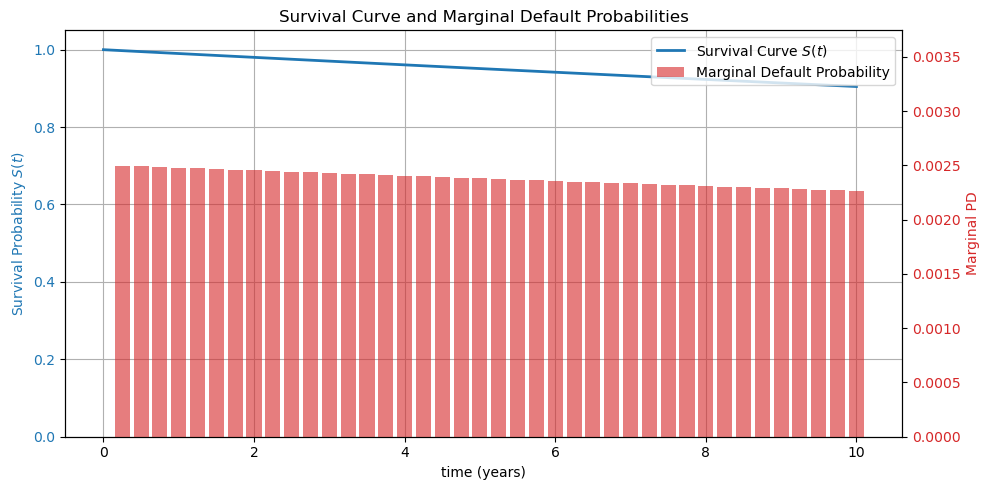

In [469]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Axe 1 : Survival curve
ax1.plot(time_grid, survival_probs , color = 'tab:blue', label = r"Survival Curve $S(t)$", linewidth = 2)
ax1.set_ylabel("Survival Probability $S(t)$", color='tab:blue')
ax1.set_ylim(0, 1.05)
ax1.tick_params(axis = 'y', labelcolor = 'tab:blue')
ax1.set_xlabel("time (years)")
ax1.grid(True)

# axe 2 : Marginales PD bars
ax2 = ax1.twinx()
ax2.bar(time_grid[1:], pd_marginal, width=0.2, alpha=0.6, color='tab:red', label="Marginal Default Probability")
ax2.set_ylabel("Marginal PD", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(pd_marginal)*1.5)

# combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Survival Curve and Marginal Default Probabilities")
plt.tight_layout()
plt.show()

### 6.6 – CVA with Time-Dependent (Increasing) Hazard Rate

In this section, we extend the CVA calculation by allowing the counterparty's default intensity (hazard rate) to increase over time.

This models the realistic assumption that credit risk may rise as the exposure matures.

---

#### 6.6.1 – Time-Dependent Hazard Rate

We define a linearly increasing hazard rate:

$$
\lambda(t) = \lambda_0 + \alpha \cdot t
$$

Where:
- $\lambda_0$ is the initial hazard rate (e.g. 0.5%),
- $\alpha$ is the slope of increase (e.g. 0.2% per year).

---

#### 6.6.2 – Survival Function

The cumulative survival function is given by:

$$
S(t) = \exp\left(-\int_0^t \lambda(u) du\right)
$$

In discrete time, we approximate the integral numerically using the trapezoidal rule:

$$
S(t_i) = \exp\left(-\sum_{j=1}^{i} \frac{\lambda(t_{j-1}) + \lambda(t_j)}{2} \cdot \Delta t \right)
$$

In [471]:
# temporal grid
time_grid = np.linspace(0, 10, 41)  # 41 points → 0.25 step

# croissant hazard rate parameters 
lambda_0 = 0.005   # 0.5 % at inception
alpha = 0.002      # linear increase

# λ(t) increasing in time
lambda_t = lambda_0 + alpha * time_grid


dt = time_grid[1] - time_grid[0]
lambda_avg = (lambda_t[:-1] + lambda_t[1:]) / 2
cum_lambda_integral = np.cumsum(lambda_avg) * dt
survival_croissant = np.exp(-cum_lambda_integral)
survival_croissant = np.insert(survival_croissant, 0, 1.0)  # S(0) = 1

#### 6.6.3 – Marginal Default Probabilities and CVA

We compute marginal default probabilities as:

$$
PD(t_i) = S(t_{i-1}) - S(t_i)
$$

Then the CVA is calculated as:

$$
\text{CVA} = (1 - R) \cdot \sum_{i=1}^{n} \text{EE}(t_i) \cdot PD(t_i)
$$

---

This method allows the CVA to reflect a realistic risk term structure, where exposure to credit loss is not uniform across time but increases with maturity.

In [473]:
pd_marginal_croissant = survival_croissant[:-1] - survival_croissant[1:]
cva_croissant = lgd * np.sum(expected_exposure[1:] * pd_marginal_croissant)
fair_cva_croissant = lgd * np.sum(fair_expected_exposure[1:] * pd_marginal_croissant)

print(f"CVA with increasing hazard rate : {cva_croissant:,.2f} €")
print(f"Fair CVA with increasing hazard rate : {fair_cva_croissant:,.2f} €")

CVA with increasing hazard rate : 37,824.29 €
Fair CVA with increasing hazard rate : 4,105.30 €


### 6.6.4 – Visualization: Survival Curve and Marginal Default Probabilities (Increasing λ)

The following plot illustrates the effect of a time-dependent, increasing hazard rate on credit risk:

- The blue line represents the survival function $S(t)$ computed using a linearly increasing hazard rate: $\lambda(t) = \lambda_0 + \alpha \cdot t$.
- The red bars show the marginal default probabilities $PD(t_i) = S(t_{i-1}) - S(t_i)$ for each time interval.

#### Interpretation:

- As the hazard rate increases over time, the probability of survival $S(t)$ decays more rapidly compared to the constant hazard case.
- Consequently, the marginal default probabilities (bar heights) increase with time — capturing the intuition that the longer a position remains open, the higher the chance of default becomes.
- This leads to a CVA that puts more weight on exposures in later periods, even though the exposure profile (EE) may be decreasing over time.

This visualization confirms the rationale for modeling credit risk with a dynamic hazard rate in long-dated derivatives like swaps.

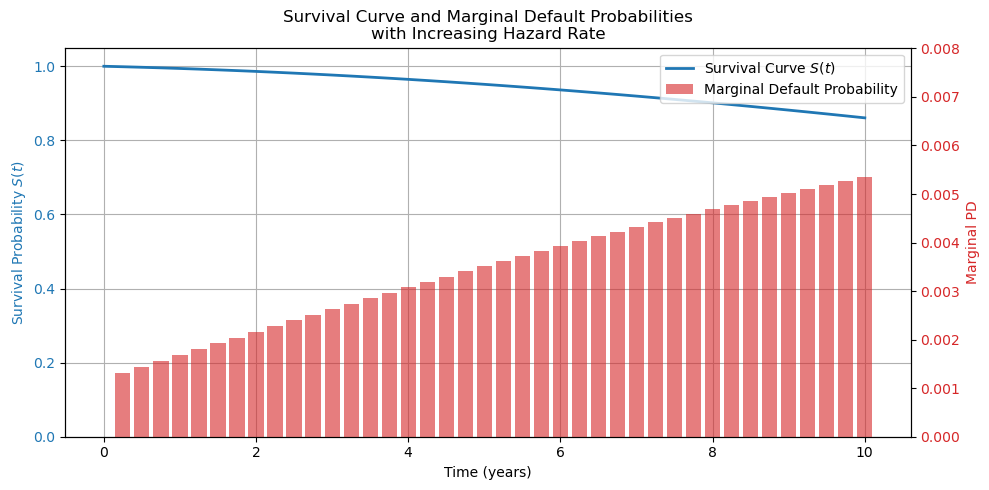

In [475]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Courbe de survie croissante
ax1.plot(time_grid, survival_croissant, color='tab:blue', linewidth=2, label=r"Survival Curve $S(t)$")
ax1.set_ylabel("Survival Probability $S(t)$", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel("Time (years)")
ax1.set_ylim(0, 1.05)
ax1.grid(True)

# Barres des PD marginales
ax2 = ax1.twinx()
ax2.bar(time_grid[1:], pd_marginal_croissant, width=0.2, color='tab:red', alpha=0.6, label="Marginal Default Probability")
ax2.set_ylabel("Marginal PD", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(pd_marginal_croissant) * 1.5)

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Survival Curve and Marginal Default Probabilities\nwith Increasing Hazard Rate")
plt.tight_layout()
plt.show()

### Summary of the different CVA computed

In [477]:
cva_values = {("2% (off-market fixed rate)", "Initial EE") : expected_exposure[0],
              ("Fair fixed rate", "Initial EE") : fair_expected_exposure[0],
              ("2% (off-market fixed rate)", "Constant PD") : cva,
              ("Fair fixed rate", "Constant PD") : fair_cva,
              ("2% (off-market fixed rate)", "Constant hazard rate") : cva_exp,
              ("Fair fixed rate", "Constant hazard rate") : fair_cva_exp,
              ("2% (off-market fixed rate)", "Increasing hazard rate") : cva_croissant,
              ("Fair fixed rate", "Increasing hazard rate") : fair_cva_croissant
    }

df_cva_pivot = pd.DataFrame.from_dict(cva_values, orient = 'index', columns = ['CVA (€)'])
df_cva_pivot.index = pd.MultiIndex.from_tuples(df_cva_pivot.index, names = ['Fixed rate','Type of PD'])
df_cva_pivot = df_cva_pivot.unstack(level = 1)
df_cva_pivot.columns = df_cva_pivot.columns.droplevel()

df_cva_pivot = df_cva_pivot[["Initial EE","Constant PD","Constant hazard rate","Increasing hazard rate"]]

In [478]:
from IPython.display import display

display(
    df_cva_pivot.style
    .format("{:,.2f} €")
    .background_gradient(cmap="OrRd")
)

Type of PD,Initial EE,Constant PD,Constant hazard rate,Increasing hazard rate
Fixed rate,,,,
2% (off-market fixed rate),"981,275.05 €","34,165.04 €","31,552.53 €","37,824.29 €"
Fair fixed rate,0.00 €,"3,120.03 €","2,983.62 €","4,105.30 €"


#### Synthesis: Impact of Initial Exposure and Credit Risk Assumptions on CVA

The table below illustrates how CVA is driven by both the economic asymmetry of the swap and the assumed credit risk model.

#### Key insights:

- **Initial exposure explains most of the gap** between the off-market and fair swap. The off-market swap starts with €981,276 of expected exposure, while the fair swap begins with zero — directly translating into a ~10× difference in CVA.
  
- **Across columns**, the CVA increases when moving from:
  - constant default probability,
  - to a constant hazard rate (continuous-time survival),
  - to a rising hazard rate (credit quality deteriorates over time).
  
- This increase is especially pronounced for the off-market swap, where long-term exposure amplifies the effect of rising default probabilities.

#### Conclusion:

> CVA is jointly driven by the shape of the exposure profile and the structure of the default model.  
> A fair swap with short-lived exposure is relatively insensitive to credit modeling choices.  
> Conversely, swaps that are economically favorable from inception — such as off-market fixed rate swaps — carry a much more material CVA, especially under dynamic default assumptions.

### 7 – Potential Future Exposure (PFE)

In addition to the Expected Exposure (EE), which represents the average potential credit exposure at each time point, we compute the Potential Future Exposure (PFE) to quantify extreme but plausible exposure levels.

#### Definition:

The PFE at level α (e.g. 95%) is defined as the α-quantile of the distribution of positive exposures across simulated scenarios:

$$
\text{PFE}_{\alpha}(t) = \text{Quantile}_\alpha\left[ \max(\text{MtM}_i(t), 0) \right]
$$

Where:
- $\text{MtM}_i(t)$ is the mark-to-market value of scenario $i$ at time $t$
- The function $\max(\cdot, 0)$ ensures we consider only positive exposures (counterparty risk)
- $\alpha$ is typically set at 95% or 99%

#### Interpretation:

- While EE gives an average view of credit risk, PFE reflects tail risk — what could happen in the worst 5% of cases.
- This is useful for setting credit limits, stress testing, or validating risk appetite under Basel requirements.

In the chart below, PFE is always above EE, and the gap increases with time, reflecting increasing uncertainty as maturity approaches.

In [481]:
alpha = 0.95

pfe_95 = np.quantile(exposure_matrix, q = alpha, axis = 0)
fair_pfe_95 = np.quantile(fair_exposure_matrix, q = alpha, axis = 0)

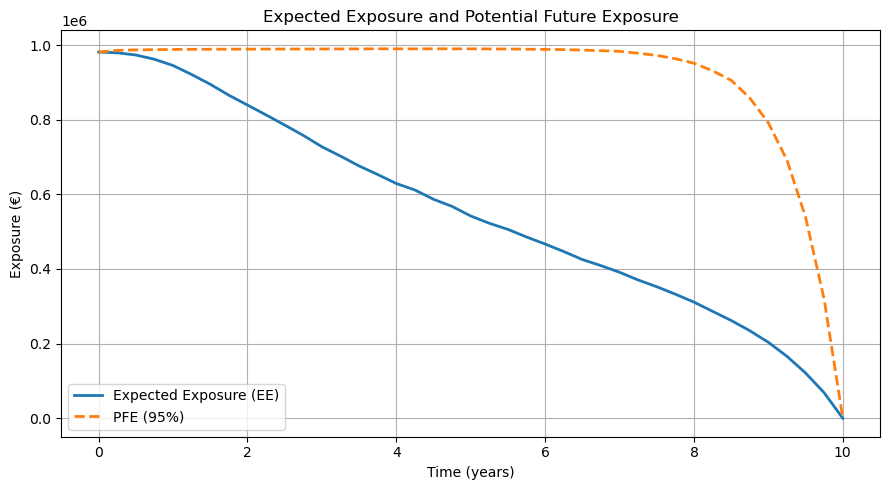

In [482]:
plt.figure(figsize=(9, 5))
plt.plot(time_grid, expected_exposure, label="Expected Exposure (EE)", linewidth=2)
plt.plot(time_grid, pfe_95, label=f"PFE ({int(alpha*100)}%)", linewidth=2, linestyle='--')
plt.title("Expected Exposure and Potential Future Exposure")
plt.xlabel("Time (years)")
plt.ylabel("Exposure (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

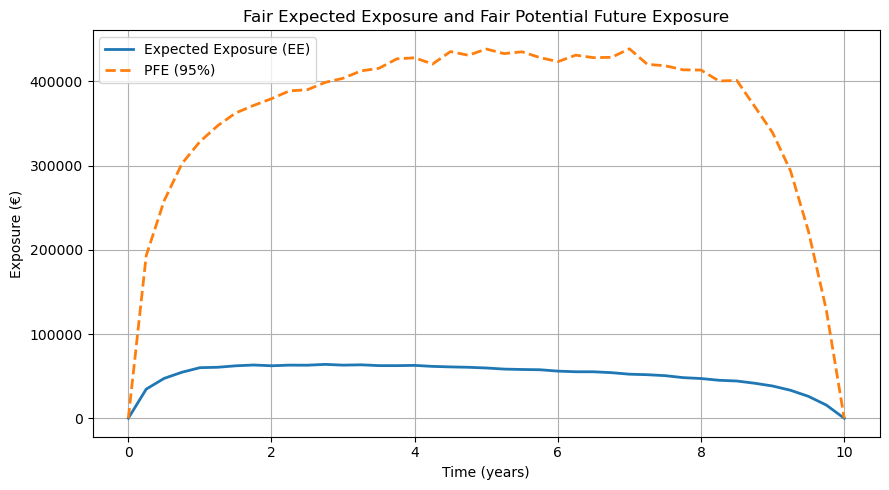

In [483]:
plt.figure(figsize=(9, 5))
plt.plot(time_grid, fair_expected_exposure, label="Expected Exposure (EE)", linewidth=2)
plt.plot(time_grid, fair_pfe_95, label=f"PFE ({int(alpha*100)}%)", linewidth=2, linestyle='--')
plt.title("Fair Expected Exposure and Fair Potential Future Exposure")
plt.xlabel("Time (years)")
plt.ylabel("Exposure (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 8 – CVA with Wrong-Way Risk (WWR)

In this section, we incorporate Wrong-Way Risk (WWR) by allowing the counterparty’s hazard rate to depend on the simulated interest rate. This models the adverse situation where the counterparty becomes more likely to default precisely when our exposure to them increases.

---

#### 8.1 – Interest-rate dependent hazard rate

We model the hazard rate as an exponential function of the short rate:

$$
\lambda(t) = \lambda_0 \cdot \exp(\gamma \cdot r(t))
$$

Where:
- $\lambda_0$ is the base hazard rate (e.g., 1% per annum),
- $r(t)$ is the simulated short rate at time $t$,
- $\gamma$ is a sensitivity coefficient (e.g., 20).

This formulation reflects that, in our swap position (payer fixed, receiver floating), the mark-to-market value increases when rates rise. Hence, so does the counterparty’s likelihood of default — a classic WWR case.

---

#### 8.2 – Survival curve and marginal PDs under WWR

Using the simulated $\lambda(t)$, we compute the survival probability:

$$
S(t) = \exp\left(- \int_0^t \lambda(u) \, du \right)
$$

Then we derive marginal default probabilities at each time step:

$$
PD(t_i) = S(t_{i-1}) - S(t_i)
$$


#### 8.3 – CVA Results with WWR

We apply the WWR-driven PDs to both exposure profiles:

- 📈 CVA (Off-market fixed rate swap): ~39,366.25 €
- 📉 CVA (Fair fixed rate swap): ~3,655.75 €

These values are significantly higher than the CVA computed under flat or non-correlated hazard rates, and highlight that:

> CVA increases when exposure and default risk become positively correlated — even if average exposure remains unchanged.

In [486]:
dt = time_grid[1] - time_grid[0]

#Modeling hazard rate
lambda_0 = 0.01   # base hazard rate
gamma = 5        # sensitivity to r(t)
mean_short_rate = r_sim.mean(axis = 0)
lambda_t = lambda_0 * np.exp(gamma * np.clip(mean_short_rate, 0, 0.05))

# Cumulative integral
lambda_avg = (lambda_t[:-1] + lambda_t[1:])/2
cum_lambda_integral = np.cumsum(lambda_avg) * dt

# Survival function
survival_wwr = np.exp(-cum_lambda_integral)
survival_wwr = np.insert(survival_wwr, 0, 1.0)

# Marginal probability default
pd_marginal_wwr = survival_wwr[:-1] - survival_wwr[1:]


In [487]:
# Off-market swap
cva_wwr = lgd * np.sum(expected_exposure[1:] * pd_marginal_wwr)
fair_cva_wwr = lgd * np.sum(fair_expected_exposure[1:] * pd_marginal_wwr)

print(f"CVA (WWR) - Off-market swap : {cva_wwr:,.2f} €")
print(f"CVA (WWR) - Fair fixed rate  : {fair_cva_wwr:,.2f} €")

CVA (WWR) - Off-market swap : 39,366.25 €
CVA (WWR) - Fair fixed rate  : 3,655.75 €


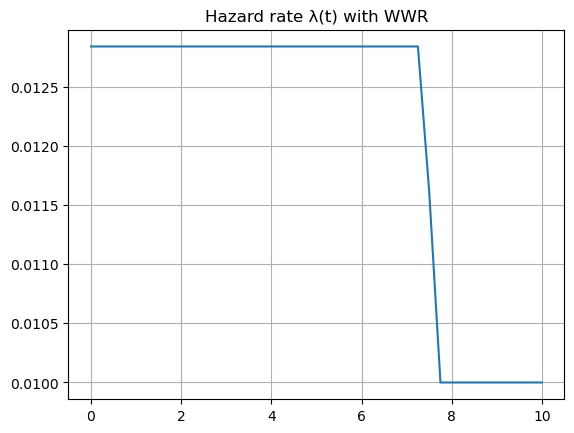

In [488]:
plt.plot(time_grid, lambda_t)
plt.title("Hazard rate λ(t) with WWR")
plt.grid()

In [489]:
print("λ(t) min:", lambda_t.min())
print("λ(t) max:", lambda_t.max())

λ(t) min: 0.01
λ(t) max: 0.012840254166877414


In [490]:
# Final Pivot Table
df_cva_pivot["Hazard (WWR)"] = [39366.25, 3655.75]

# Affichage stylisé
display(
    df_cva_pivot.style
    .format("{:,.2f} €")
    .background_gradient(cmap="OrRd", subset=df_cva_pivot.columns[1:])  # met en valeur les colonnes de CVA
    .set_caption("Final CVA Table – Including Wrong-Way Risk (WWR)")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "caption", "props": [("text-align", "center"), ("font-weight", "bold"), ("font-size", "14px")]}
    ])
)

Type of PD,Initial EE,Constant PD,Constant hazard rate,Increasing hazard rate,Hazard (WWR)
Fixed rate,,,,,
2% (off-market fixed rate),"981,275.05 €","34,165.04 €","31,552.53 €","37,824.29 €","39,366.25 €"
Fair fixed rate,0.00 €,"3,120.03 €","2,983.62 €","4,105.30 €","3,655.75 €"


### Commentary – Interpretation of the Final CVA Table

This table provides a comprehensive summary of Credit Valuation Adjustment (CVA) values under various credit risk modeling assumptions:

- 🔹 The first column shows the initial expected exposure (EE) at time t = 0. This value plays a major role in determining the overall magnitude of CVA.
- 🔹 The following columns compare CVA outcomes under four different assumptions for default modeling:
  - 📘 Constant PD: a flat default probability applied over time
  - 📗 Constant hazard rate: continuous-time survival model with constant intensity
  - 📙 Increasing hazard rate: captures a growing likelihood of default over time
  - 📕 Market-dependent hazard (WWR): introduces Wrong-Way Risk by linking default risk to simulated interest rates

#### Key insights:

- The off-market swap shows significantly higher CVA across all models due to its large initial exposure and favorable mark-to-market profile.
- The fair fixed rate swap has low CVA values and remains relatively insensitive to credit modeling assumptions.
- Incorporating Wrong-Way Risk (WWR) increases CVA moderately — especially for the off-market swap — highlighting the impact of an adverse correlation between exposure and credit deterioration.

> ✅ This final comparison clearly illustrates how both the product’s economic structure and the credit risk assumptions shape counterparty risk valuation.

## Conclusion

This simulation-based approach shows how CVA reacts to changes in both market exposure and credit modeling. The addition of Wrong-Way Risk produces realistic and measurable increases in CVA for asymmetric positions. This framework is extendable to other OTC derivatives and can support credit risk analysis for pricing, limit setting, or stress testing.